# Modeling

For the modeling portion I will begin with some basic models and not do any feature engineering or hyperparameter tuning. I will be using the following models:

* Logistic Regression
* Random Forest
* XGBoost (extreme gradient boosting trees)

Some questions that I wanted to answer using machine learning:

* How accuratetly and efficiently can the model predict the placement of a player?
* What is the most impactful composition that determines predicting rank?
* What are the most impactful champions along with their item set ups that determines predicting rank?

Evaluating the models:

* Accuracy, f1-score
* AUCROC for multiclass classification

After some evaluation of the basic models I will fine tune the models with hyperparameters then select the best performer:

* Feature Engineering
* GridsearchCV
* Optuna (TPE)

And finally re-evaluate the best forming model:

* Accuracy, f1-score
* AUCROC for multiclass classification

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import re
import optuna
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.style.use('seaborn')
FONT = {'size'   : 14}
plt.rc('font', **FONT)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
df = pd.read_csv('TFT_Challenger_NA_Data.csv')

In [4]:
df.drop(['match_id'], axis=1, inplace=True)
X = df.loc[:, df.columns != 'placement']
y = df['placement']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69688 entries, 0 to 69687
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   game_length      69688 non-null  float64
 1   game_version     69688 non-null  object 
 2   time_eliminated  69688 non-null  float64
 3   gold_left        69688 non-null  int64  
 4   last_round       69688 non-null  int64  
 5   level            69688 non-null  int64  
 6   placement        69688 non-null  int64  
 7   combination      69688 non-null  object 
 8   champion         69688 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 4.8+ MB


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)

## LogisticRegression

In [7]:
#logistic regression
columns_to_transform = ['game_version', 'combination', 'champion']
ct = ColumnTransformer([('categ', OneHotEncoder(handle_unknown='ignore'), columns_to_transform)], remainder='passthrough')

scaler = StandardScaler(with_mean=False)
    
log_reg = LogisticRegression(max_iter=5000)

pipeline = make_pipeline(ct, scaler, log_reg)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categ',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['game_version',
                                                   'combination',
                                                   'champion'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression', LogisticRegression(max_iter=5000))])

In [8]:
print("training accuracy: ", pipeline.score(X_train, y_train))
print('')
y_preds = pipeline.predict(X_test)
print(classification_report(y_test, y_preds))

training accuracy:  1.0

              precision    recall  f1-score   support

           1       0.78      0.64      0.70      1718
           2       0.58      0.81      0.68      1744
           3       0.60      0.68      0.64      1704
           4       0.72      0.65      0.68      1723
           5       0.83      0.61      0.71      1757
           6       0.83      0.60      0.70      1785
           7       0.65      0.72      0.68      1743
           8       0.69      0.83      0.75      1764

    accuracy                           0.69     13938
   macro avg       0.71      0.69      0.69     13938
weighted avg       0.71      0.69      0.69     13938



Inspecting the report I can see that the model has optimized to predict most of the placement of the 5th and 6th placed players. The logistic regression model also relevantly predicted the placement of the 8th and 2nd placed players.

Overall the accuracy of the model is 69% with a training accuracy of 100%, the model is overfit. After initial inspection of the basic modeling I will carry on with VIFs to better handle overfitting.

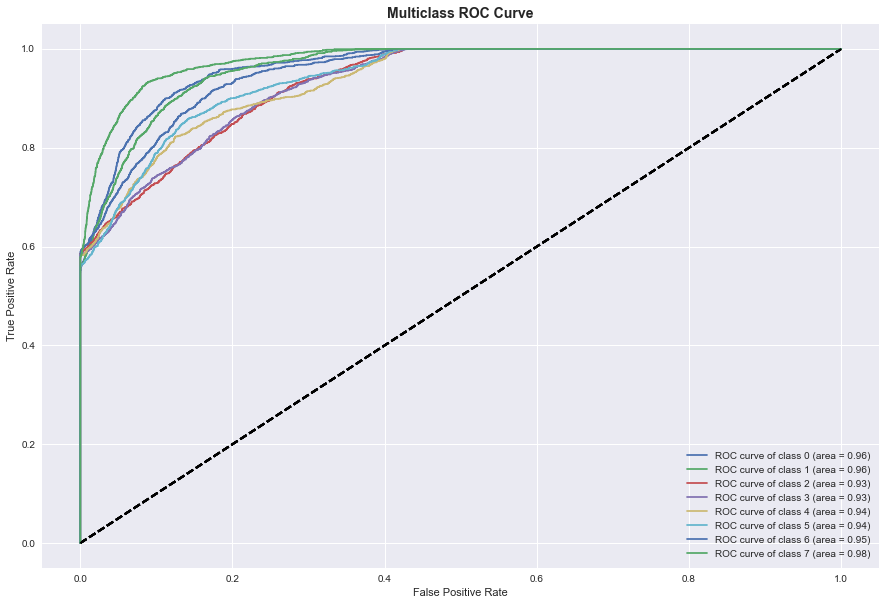

In [9]:
plt.figure(figsize=(15,10))
plt.title('Multiclass ROC Curve', font=FONT, weight='bold')
for i in range(8):
    y_preds_prob = pipeline.predict_proba(X_test)[:,i]
    fpr, tpr, thresholds = roc_curve(y_test,  y_preds_prob, pos_label=i+1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc))
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right");

In [10]:
y_preds_prob = pipeline.predict_proba(X_test)

print('Area Under Curve "One vs. Rest"')
print(roc_auc_score(y_test, y_preds_prob, multi_class='ovr'))
print('')
print('Area Under Curve "One vs. One"')
print(roc_auc_score(y_test, y_preds_prob, multi_class='ovo'))

Area Under Curve "One vs. Rest"
0.9492179086934351

Area Under Curve "One vs. One"
0.9492335121271244


One vs. Rest is one way we can evaluate the area under the curve score. We reduce the multiclass classification output to just binary by comparing each class each all the others at the same time. This gets repeated for each class present and then a weighted average is the final output for the AUC score.

Another way to evaluate the AUC is with One vs. One. The difference between the two is that OvO compares all the possible 2-class combinations of the data. The final output is the average of all the OvO scores.

Inspecting the plots and scores we see that our model fits really well to the data.

In [11]:
#get the feature names from the column transformer
transformed_X = pd.DataFrame(ct.fit_transform(X_train).toarray())
transformed_X.columns = pipeline.named_steps['columntransformer'].get_feature_names_out()

In [12]:
feature_names = transformed_X
coefficients = pipeline.named_steps['logisticregression'].coef_.flatten()

zipped = zip(feature_names, coefficients)
df = pd.DataFrame(zipped, columns=["feature", "value"])
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

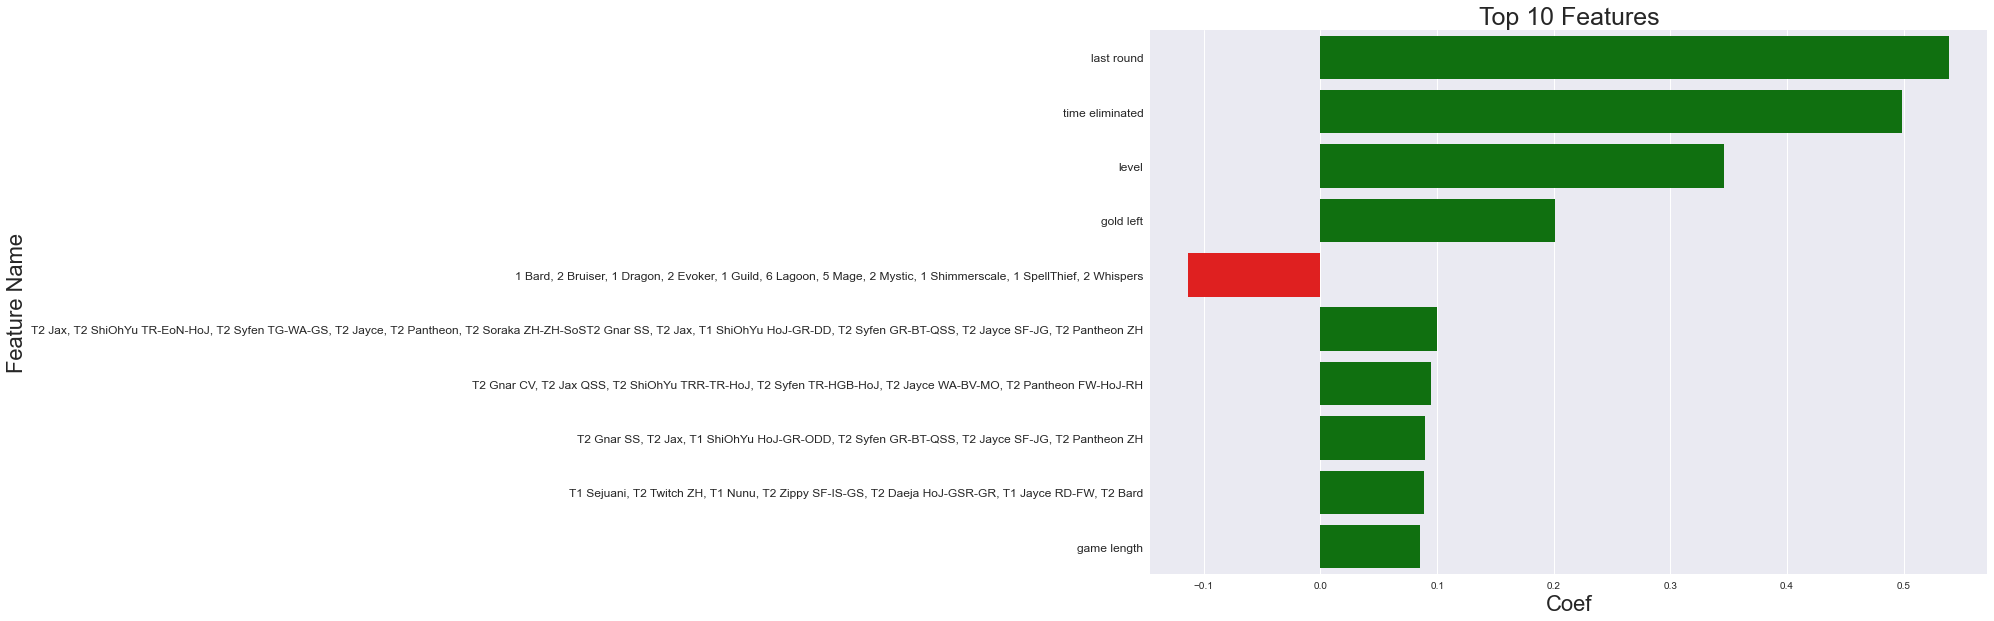

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.barplot(y="feature",
            x="value",
            data=df.head(10),
           palette=df.head(10)["colors"])
labels = ['last round', 'time eliminated', 'level', 'gold left',
          "1 Bard, 2 Bruiser, 1 Dragon, 2 Evoker, 1 Guild, 6 Lagoon, 5 Mage, 2 Mystic, 1 Shimmerscale, 1 SpellThief, 2 Whispers",
          "T2 Jax, T2 ShiOhYu TR-EoN-HoJ, T2 Syfen TG-WA-GS, T2 Jayce, T2 Pantheon, T2 Soraka ZH-ZH-SoS"
          "T2 Gnar SS, T2 Jax, T1 ShiOhYu HoJ-GR-DD, T2 Syfen GR-BT-QSS, T2 Jayce SF-JG, T2 Pantheon ZH",
          "T2 Gnar CV, T2 Jax QSS, T2 ShiOhYu TRR-TR-HoJ, T2 Syfen TR-HGB-HoJ, T2 Jayce WA-BV-MO, T2 Pantheon FW-HoJ-RH",
          "T2 Gnar SS, T2 Jax, T1 ShiOhYu HoJ-GR-ODD, T2 Syfen GR-BT-QSS, T2 Jayce SF-JG, T2 Pantheon ZH",
          "T1 Sejuani, T2 Twitch ZH, T1 Nunu, T2 Zippy SF-IS-GS, T2 Daeja HoJ-GSR-GR, T1 Jayce RD-FW, T2 Bard",
         "game length"]
ax.set_yticklabels(labels, fontsize=12)
ax.set_title("Top 10 Features", fontsize=25)
ax.set_xlabel("Coef", fontsize=22)
ax.set_ylabel("Feature Name", fontsize=22)
plt.tight_layout();

The `last_round` feature was the most positive impact in the model, while the most negative impact was `game_length`. Both of these align with the overall idea of the game. Players that last all the way to the end are going to place high in rank, and the length of the overall game will negatively determine placement.

The most impactful composition that determines predicting rank for the logistic regression model is:
1 Bard, 2 Bruiser, 1 Dragon, 2 Evoker, 1 Guild, 6 Lagoon, 5 Mage, 2 Mystic, 1 Shimmerscale, 1 SpellThief, 2 Whispers.

While the most impact champions and items were:
            
Tier 2 Gnar with a Shroud, Tier 2 Jax, Tier 1 Shi'Oh'Yu with Hand of Justice - Guinsoos Rageblade - DeathsDefiance,
Tier 2 Sy'fen with Guinsoos Rageblade - Bloodthirster - Quicksilver, Tier 2 Jayce with Sunfire - Jeweled Gauntlet, and Tier 2 Pantheon with Zekes Herald. 

## Random Forest

In [14]:
rf_clf = RandomForestClassifier()

pipeline = make_pipeline(ct, scaler, rf_clf)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categ',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['game_version',
                                                   'combination',
                                                   'champion'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('randomforestclassifier', RandomForestClassifier())])

In [15]:
print("training accuracy: ", pipeline.score(X_train, y_train))
print('')
y_preds = pipeline.predict(X_test)
print(classification_report(y_test, y_preds))

training accuracy:  1.0

              precision    recall  f1-score   support

           1       0.76      0.88      0.82      1718
           2       0.83      0.75      0.79      1744
           3       0.84      0.80      0.82      1704
           4       0.77      0.76      0.77      1723
           5       0.71      0.75      0.73      1757
           6       0.75      0.70      0.72      1785
           7       0.77      0.73      0.75      1743
           8       0.83      0.88      0.85      1764

    accuracy                           0.78     13938
   macro avg       0.78      0.78      0.78     13938
weighted avg       0.78      0.78      0.78     13938



Inspecting the report I can see that the model has optimized to predict most of the placement of the 2nd, 3rd, and 8th placed players. The random forest model also relevantly predicted the placement of the 1st and 8th placed players.

Overall the accuracy of the model is 78% with a training accuracy of 100%, the model is overfit. After initial inspection of the basic modeling I will carry on with VIFs to better handle overfitting.

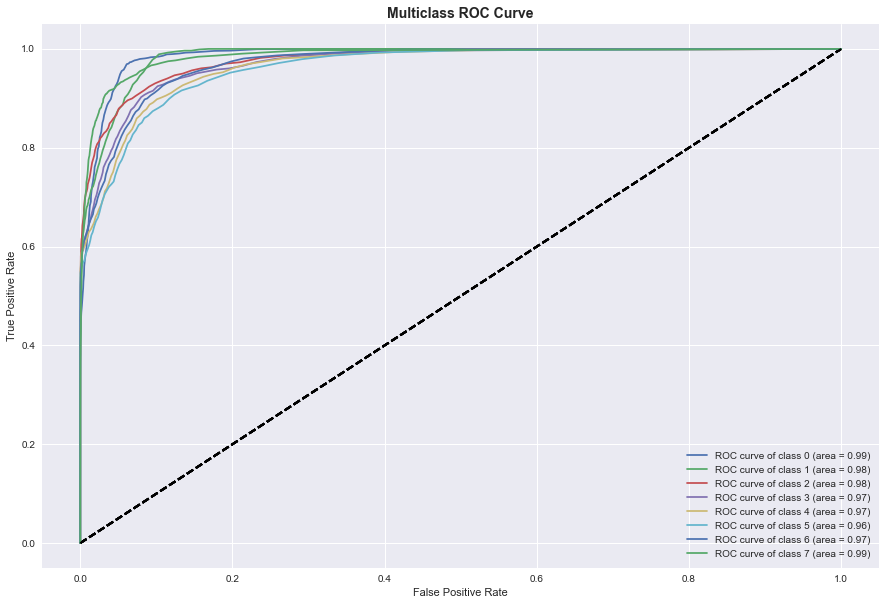

In [16]:
plt.figure(figsize=(15,10))
plt.title('Multiclass ROC Curve', font=FONT, weight='bold')
for i in range(8):
    y_preds_prob = pipeline.predict_proba(X_test)[:,i]
    fpr, tpr, thresholds = roc_curve(y_test,  y_preds_prob, pos_label=i+1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc))
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right");

In [17]:
y_preds_prob = pipeline.predict_proba(X_test)

print('Area Under Curve "One vs. Rest"')
print(roc_auc_score(y_test, y_preds_prob, multi_class='ovr'))
print('')
print('Area Under Curve "One vs. One"')
print(roc_auc_score(y_test, y_preds_prob, multi_class='ovo'))


Area Under Curve "One vs. Rest"
0.975164998576147

Area Under Curve "One vs. One"
0.975205335650539


Inspecting the plots and scores we see that random forest model fits much better to the data than the logistic regression model. This is likely due to overfitting.

In [18]:
coefficients = pipeline.named_steps['randomforestclassifier'].feature_importances_.flatten()

zipped = zip(feature_names, coefficients)
df = pd.DataFrame(zipped, columns=["feature", "value"])
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

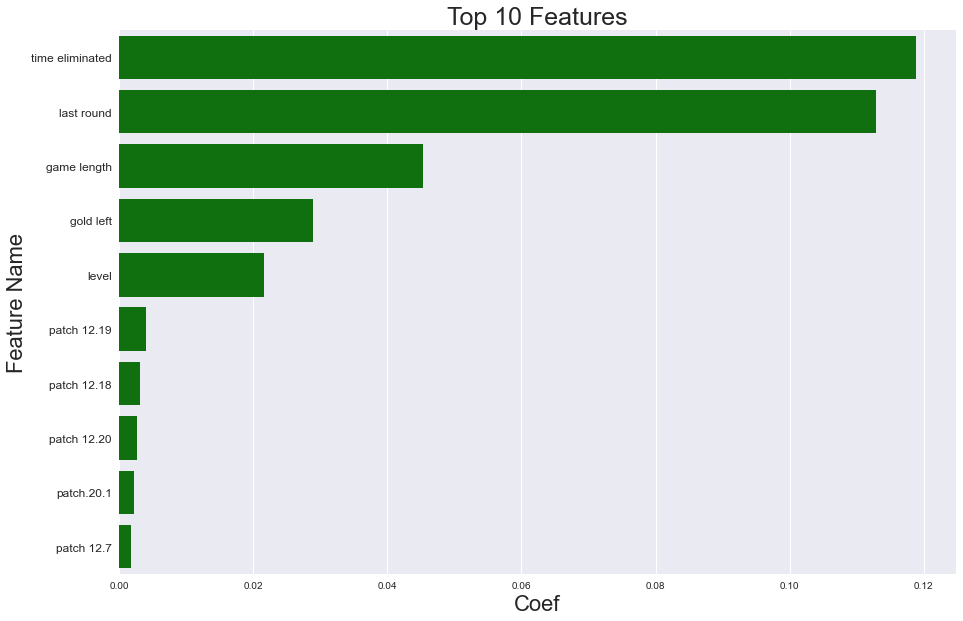

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.barplot(y="feature",
            x="value",
            data=df.head(10),
           palette=df.head(10)["colors"])
labels = ['time eliminated', 'last round', 'game length', 'gold left', 'level', 'patch 12.19', 'patch 12.18',
          'patch 12.20', 'patch.20.1', 'patch 12.7']
ax.set_yticklabels(labels, fontsize=12)
ax.set_title("Top 10 Features", fontsize=25)
ax.set_xlabel("Coef", fontsize=22)
ax.set_ylabel("Feature Name", fontsize=22);

This time around the time_eliminated feature was the most positive impactor in the model, while last_round was the the second most positive impactor. 

For the random forest model there is not much importance given to the the composition of a player or their champions.

## XGBoost

In [20]:
xgb_clf = xgb.XGBClassifier()


pipeline = make_pipeline(ct, scaler, xgb_clf)
pipeline.fit(X_train, y_train)

[13:30:08] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categ',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['game_version',
                                                   'combination',
                                                   'champion'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()

In [21]:
print("training accuracy: ", pipeline.score(X_train, y_train))
print('')
y_preds = pipeline.predict(X_test)
print(classification_report(y_test, y_preds))

training accuracy:  0.6481255605381165

              precision    recall  f1-score   support

           1       0.65      0.79      0.71      1718
           2       0.67      0.62      0.65      1744
           3       0.71      0.68      0.69      1704
           4       0.53      0.48      0.51      1723
           5       0.45      0.52      0.48      1757
           6       0.50      0.41      0.45      1785
           7       0.50      0.49      0.50      1743
           8       0.72      0.74      0.73      1764

    accuracy                           0.59     13938
   macro avg       0.59      0.59      0.59     13938
weighted avg       0.59      0.59      0.59     13938



Inspecting the report I can see that the model has optimized to predict most of the placement of the 8th, and 3rd placed players. The extreme gradient boost model also relevantly predicted the placement of the 1st and 8th placed players.

Overall the accuracy of the model is 59% with a training accuracy of 64.7%, the model is well fit I would like to check the AUCROC to see how well the data fits.

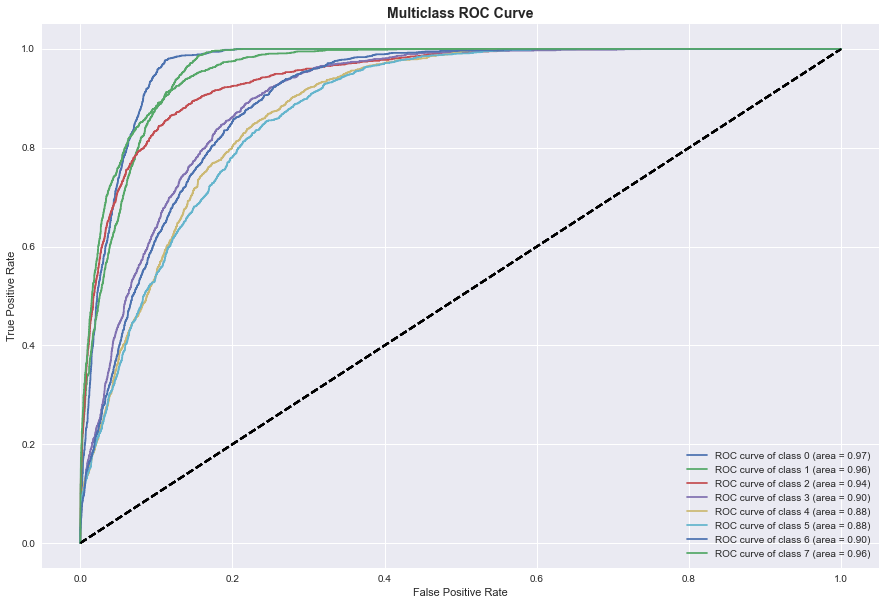

In [22]:
plt.figure(figsize=(15,10))
plt.title('Multiclass ROC Curve', font=FONT, weight='bold')
for i in range(8):
    y_preds_prob = pipeline.predict_proba(X_test)[:,i]
    fpr, tpr, thresholds = roc_curve(y_test,  y_preds_prob, pos_label=i+1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc))
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right");

In [23]:
y_preds_prob = pipeline.predict_proba(X_test)

print('Area Under Curve "One vs. Rest"')
print(roc_auc_score(y_test, y_preds_prob, multi_class='ovr'))
print('')
print('Area Under Curve "One vs. One"')
print(roc_auc_score(y_test, y_preds_prob, multi_class='ovo'))

Area Under Curve "One vs. Rest"
0.9246945686417422

Area Under Curve "One vs. One"
0.924888863837505


Although the model has a much lower accuracy than the last two, it does not suffer from overfitting. I can conclude that XGBoost is the choice here for basic modeling. What are the important features in this model?

In [24]:
coefficients = pipeline.named_steps['xgbclassifier'].feature_importances_.flatten()

zipped = zip(feature_names, coefficients)
df = pd.DataFrame(zipped, columns=["feature", "value"])
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

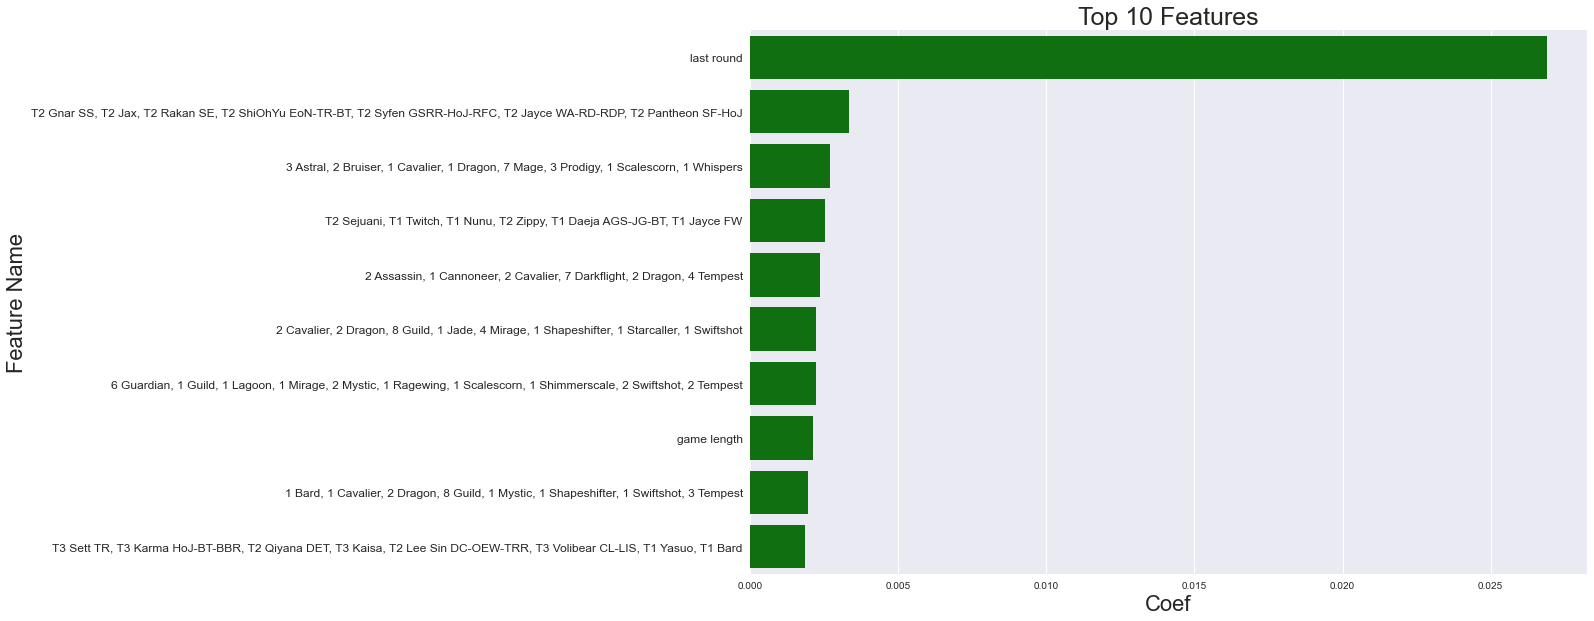

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.barplot(y="feature",
            x="value",
            data=df.head(10),
           palette=df.head(10)["colors"])
labels = ['last round',
          "T2 Gnar SS, T2 Jax, T2 Rakan SE, T2 ShiOhYu EoN-TR-BT, T2 Syfen GSRR-HoJ-RFC, T2 Jayce WA-RD-RDP, T2 Pantheon SF-HoJ",
          "3 Astral, 2 Bruiser, 1 Cavalier, 1 Dragon, 7 Mage, 3 Prodigy, 1 Scalescorn, 1 Whispers",
          "T2 Sejuani, T1 Twitch, T1 Nunu, T2 Zippy, T1 Daeja AGS-JG-BT, T1 Jayce FW",
          "2 Assassin, 1 Cannoneer, 2 Cavalier, 7 Darkflight, 2 Dragon, 4 Tempest",
          "2 Cavalier, 2 Dragon, 8 Guild, 1 Jade, 4 Mirage, 1 Shapeshifter, 1 Starcaller, 1 Swiftshot",
          "6 Guardian, 1 Guild, 1 Lagoon, 1 Mirage, 2 Mystic, 1 Ragewing, 1 Scalescorn, 1 Shimmerscale, 2 Swiftshot, 2 Tempest",
          "game length",
          "1 Bard, 1 Cavalier, 2 Dragon, 8 Guild, 1 Mystic, 1 Shapeshifter, 1 Swiftshot, 3 Tempest",
          "T3 Sett TR, T3 Karma HoJ-BT-BBR, T2 Qiyana DET, T3 Kaisa, T2 Lee Sin DC-OEW-TRR, T3 Volibear CL-LIS, T1 Yasuo, T1 Bard"
          ]
ax.set_yticklabels(labels, fontsize=12)
ax.set_title("Top 10 Features", fontsize=25)
ax.set_xlabel("Coef", fontsize=22)
ax.set_ylabel("Feature Name", fontsize=22);

Just like in log reg, the XGBoost models most important feature is `last_round`. 

The composition with most importance is: T2 Gnar SS, T2 Jax, T2 Rakan SE, T2 ShiOhYu EoN-TR-BT, T2 Syfen GSRR-HoJ-RFC, T2 Jayce WA-RD-RDP, T2 Pantheon SF-HoJ

While the synergy with most importance is: 3 Astral, 2 Bruiser, 1 Cavalier, 1 Dragon, 7 Mage, 3 Prodigy, 1 Scalescorn, 1 Whispers

# Feature Engineering & Hyperparameter Tuning

How would the other two models perform after some feature engineering and tuning though? There has to be multicollinearity that log reg and random forest cannot handle as well as the extreme gradient boost ensemble method. With a set threshhold of 10 I will remove some features from the dataset to see which is producing multicollinearity

In [26]:
vif_data = pd.DataFrame()
cols_of_interest = X[['game_length', 'time_eliminated', 'gold_left', 'last_round', 'level']]
vif_data['features'] = cols_of_interest.columns
vif_data['VIF'] = [variance_inflation_factor(cols_of_interest.values, i) for i in range(len(cols_of_interest.columns))]
vif_data

,features,VIF
0,game_length,108.520999
1,time_eliminated,1957.712333
2,gold_left,1.332831
3,last_round,1904.525595
4,level,153.730299


Let's try dropping `time_eliminated` and see if we still have multicollinearity.

In [27]:
vif_data = pd.DataFrame()
cols_of_interest = X[['game_length', 'gold_left', 'last_round', 'level']]
vif_data['features'] = cols_of_interest.columns
vif_data['VIF'] = [variance_inflation_factor(cols_of_interest.values, i) for i in range(len(cols_of_interest.columns))]
vif_data

,features,VIF
0,game_length,101.579756
1,gold_left,1.331969
2,last_round,71.446311
3,level,152.335557


It was drastically reduced, perhaps further remove `level` as it wasn't an important feature in any of the models but it has high multicollinearity with the rest of the independent features.

In [28]:
vif_data = pd.DataFrame()
cols_of_interest = X[['game_length', 'gold_left', 'last_round']]
vif_data['features'] = cols_of_interest.columns
vif_data['VIF'] = [variance_inflation_factor(cols_of_interest.values, i) for i in range(len(cols_of_interest.columns))]
vif_data

,features,VIF
0,game_length,46.702248
1,gold_left,1.320154
2,last_round,46.653401


We still have VIFs higher than 10, I will remove `game_length` here.

In [29]:
vif_data = pd.DataFrame()
cols_of_interest = X[['gold_left', 'last_round']]
vif_data['features'] = cols_of_interest.columns
vif_data['VIF'] = [variance_inflation_factor(cols_of_interest.values, i) for i in range(len(cols_of_interest.columns))]
vif_data

,features,VIF
0,gold_left,1.317137
1,last_round,1.317137


Now for a final check to see if we fixed the overfitting problem.

In [30]:
X_2 = X.copy()
X_2.drop(columns=['game_length', 'level', 'time_eliminated'])

,game_version,gold_left,last_round,combination,champion
0,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,0,30,"{'Set7_Cavalier': 2, 'Set7_Dragon': 2, 'Set7_D...","{'TFT7_Sejuani': {'items': [], 'tier': 1}, 'TF..."
1,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,5,30,"{'Set7_Bard': 1, 'Set7_Cavalier': 2, 'Set7_Dra...","{'TFT7_Leona': {'items': [], 'tier': 2}, 'TFT7..."
2,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,23,26,"{'Set7_Astral': 5, 'Set7_Bruiser': 2, 'Set7_Ma...",{'TFT7_Vladimir': {'items': ['TFT_Item_ThiefsG...
3,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,5,41,"{'Set7_Bard': 1, 'Set7_Cannoneer': 2, 'Set7_Ev...",{'TFT7_Zyra': {'items': ['TFT_Item_ZekesHerald...
4,Version 12.20.474.8882 (Oct 20 2022/13:06:55) ...,20,41,"{'Set7_Dragon': 1, 'Set7_Dragonmancer': 8, 'Se...","{'TFT7_Sett': {'items': [], 'tier': 3}, 'TFT7_..."
...,...,...,...,...,...
69683,Version 12.19.471.6581 (Oct 03 2022/10:43:59) ...,15,34,"{'Set7_Dragon': 1, 'Set7_Dragonmancer': 6, 'Se...",{'TFT7_Sett': {'items': ['TFT4_Item_OrnnRocket...
69684,Version 12.19.471.6581 (Oct 03 2022/10:43:59) ...,1,28,"{'Set7_Bard': 1, 'Set7_Cavalier': 2, 'Set7_Dra...","{'TFT7_Sejuani': {'items': [], 'tier': 2}, 'TF..."
69685,Version 12.19.471.6581 (Oct 03 2022/10:43:59) ...,0,31,"{'Set7_Bard': 1, 'Set7_Cavalier': 1, 'Set7_Dra...","{'TFT7_Sejuani': {'items': [], 'tier': 1}, 'TF..."
69686,Version 12.19.471.6581 (Oct 03 2022/10:43:59) ...,0,30,"{'Set7_Astral': 3, 'Set7_Dragon': 4, 'Set7_Evo...",{'TFT7_DragonGold': {'items': ['TFT_Item_Thief...


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, train_size=0.8)

log_reg = LogisticRegression(max_iter=5000)

pipeline = make_pipeline(ct, scaler, log_reg)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categ',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['game_version',
                                                   'combination',
                                                   'champion'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression', LogisticRegression(max_iter=5000))])

In [32]:
print("training accuracy: ", pipeline.score(X_train, y_train))
print('')
print("test accuracy: ", pipeline.score(X_test, y_test))

training accuracy:  1.0

test accuracy:  0.6846032429329889


In [33]:
rf_clf = RandomForestClassifier()

pipeline = make_pipeline(ct, scaler, rf_clf)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categ',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['game_version',
                                                   'combination',
                                                   'champion'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('randomforestclassifier', RandomForestClassifier())])

In [34]:
print("training accuracy: ", pipeline.score(X_train, y_train))
print('')
print("test accuracy: ", pipeline.score(X_test, y_test))

training accuracy:  1.0

test accuracy:  0.7765820060266896


In [35]:
xgb_clf = xgb.XGBClassifier()


pipeline = make_pipeline(ct, scaler, xgb_clf)
pipeline.fit(X_train, y_train)

[13:34:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categ',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['game_version',
                                                   'combination',
                                                   'champion'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()

In [36]:
print("training accuracy: ", pipeline.score(X_train, y_train))
print('')
print("test accuracy: ", pipeline.score(X_test, y_test))

training accuracy:  0.6498116591928251

test accuracy:  0.5821495192997561


Overall removing the features has no impact on the overfitting problem. Perhaps logistic regression and random forest cannot handle the variance in the data compared to the black box model.

We could create new features based on the old but since removing the high varianced features did not work I will continue to use all the features as is for the next step.

Now I will run a GridsearchCV to optimize some hyperparameters and hopefully deal with overfitting better. GridsearchCV is computationally intensive therefore I will be limiting the amount of parameters to run through.

### GridsearchCV

In [94]:
param_grid = {
    'xgb': {
        'model': xgb.XGBClassifier(),
        'params': {
            'xgb__max_depth': [4, 5, 6, 8, 10],
            'xgb__learning_rate': np.arange(5e-2, 3e-1),
            'xgb__min_child_weight': np.arange(1,6,2),
            'xgb__reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
        }
    },
    'rf': {
        'model': RandomForestClassifier(),
        'params': {
            'rf__max_depth': [2, 4, 8, 16, 36, 64],
            'rf__n_estimators': [64, 128, 256],
            'rf__criterion' : ['gini', 'entropy']
            
        }
    },
    'log_reg': {
        'model': LogisticRegression(),
        'params': {
            'log_reg__C': np.arange(1, 5),
            'log_reg__max_iter': [2000, 3000, 5000],
            'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear']
        }
    }
}

* `max_depth` tune how big the "tree" in height will be,
* `learning_rate` tune how big of a step we want the algorithm to take,
* `min_child_weight` define the min number of samples that a node can represent in order to be split further
* `reg_alpha` tune the degree of regularization

* `n_estimators` tune the number of trees in the forest
* `criterion` tune the function to measure the quality of a tree split

* `C` tune the strength of regularization (inverse of regularization)
* `max_iter` max number of iterations taken for solvers to converge
* `solver` algorithm to use in optimization

In [97]:
scores = []
columns_to_transform = ['game_version', 'combination', 'champion']
ct = ColumnTransformer([('categ', OneHotEncoder(handle_unknown='ignore'), columns_to_transform)], remainder='passthrough')
scaler = StandardScaler(with_mean=False)
   
for model_name, mp in param_grid.items():
    pipe = Pipeline([
        ('categ', ct),
        ('scaler', scaler),
        (model_name, mp['model'])
    ])
    clf = GridSearchCV(estimator = pipe, param_grid = mp['params'], cv=5, scoring='accuracy', n_jobs=-1, error_score="raise")
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

[11:40:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [99]:
gridsearchcv_scores = pd.DataFrame(scores, columns=['model', 'best_score',
                                                    'best_params'])
gridsearchcv_scores

,model,best_score,best_params
0,xgb,0.593327,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':..."
1,rf,0.517184,"{'rf__criterion': 'entropy', 'rf__max_depth': ..."
2,log_reg,0.650870,"{'log_reg__C': 1, 'log_reg__max_iter': 2000, '..."


In [103]:
clf.best_estimator_

Pipeline(steps=[('categ',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categ',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['game_version',
                                                   'combination',
                                                   'champion'])])),
                ('scaler', StandardScaler(with_mean=False)),
                ('log_reg',
                 LogisticRegression(C=1, max_iter=2000, solver='newton-cg'))])

We saw little to no improvements when using GridsearchCV, this could be because of parameter choices. Perhaps the algorithm did not have sufficient depth-search since we are limited on CPU power I had to cut down on the amount of iterations. 

I would like to attempt using the Optuna framework. Optuna makes use of the Tree-structured Parzen Estimator algorithm. For more information on TPE this paper explains it best: [Algorithms for Hyper-Parameters Optimization](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)
Using Optuna we are allowed more room to make deeper parameter searchers due to how fast the optimization computes.
For more information on how Optuna works check out their site: [Optuna](https://optuna.readthedocs.io/en/stable/index.html)

With Optuna I will be adding the n_estimators parameter for xgboost since we have more computation power compared to gridsearchcv.

### Optuna

In [123]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)

    columns_to_transform = ['game_version', 'combination', 'champion']
    ct = ColumnTransformer([('categ', OneHotEncoder(handle_unknown='ignore'), columns_to_transform)], remainder='passthrough')

    classifier_name = trial.suggest_categorical("classifier", ["LogisticRegression", "RandomForest", "XGBClassifier"])

    scaler_name = trial.suggest_categorical("scaler", ['standard', 'robust'])

    if scaler_name == "standard":
        scaler = StandardScaler(with_mean=False)
    else:
        scaler = RobustScaler(with_centering=False)

    if classifier_name == "LogisticRegression":
        logreg_c = trial.suggest_float("logreg_c", 1e-10, 1e10, log=True)
        logreg_solver = trial.suggest_categorical("logreg_solver", ['newton-cg', 'lbfgs', 'liblinear'])
        logreg_max_iter = trial.suggest_int("logreg_max_iter", 1000, 5000, log=True)
        classifier_obj = LogisticRegression(C=logreg_c, max_iter=logreg_max_iter, solver=logreg_solver)
    elif classifier_name == "RandomForest":
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 64, log=True)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 5, 300, log=True)
        rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators,
                                                criterion=rf_criterion)
    else:
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 32, log=True)
        xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 1e-3, 1e-2, log=True)
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 5, 300, log=True)
        xgb_min_child_weight = trial.suggest_int("xgb_min_child_weight", 1, 10, log=True)
        xgb_reg_alpha = trial.suggest_float("xgb_reg_alpha", 1e-2, 5e-2, log=True)
        classifier_obj = xgb.XGBClassifier(max_depth=xgb_max_depth, learning_rate=xgb_learning_rate,
                                       n_estimators=xgb_n_estimators, min_child_weight=xgb_min_child_weight,
                                          reg_alpha=xgb_reg_alpha)

    pipeline = make_pipeline(ct, scaler, classifier_obj)
    pipeline.fit(X_train, y_train)

    preds = pipeline.predict(X_test)

    return accuracy_score(preds, y_test)

In [124]:
seed = np.random.seed(42)
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed), directions=["maximize"])
print(f"Sampler is {study.sampler.__class__.__name__}")

[I 2022-11-01 13:43:47,354] A new study created in memory with name: no-name-96646c17-8a5d-4915-9f8b-ca421d361ce8


Sampler is TPESampler


In [125]:
study.optimize(objective, n_trials=100)

[13:43:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-01 13:44:15,997] Trial 0 finished with value: 0.49167742861242647 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'standard', 'xgb_max_depth': 5, 'xgb_learning_rate': 0.0018500779393477353, 'xgb_n_estimators': 120, 'xgb_min_child_weight': 3, 'xgb_reg_alpha': 0.015509717714594494}. Best is trial 0 with value: 0.49167742861242647.
[I 2022-11-01 13:44:17,986] Trial 1 finished with value: 0.36920648586597793 and parameters: {'classifier': 'RandomForest', 'scaler': 'standard', 'rf_max_depth': 10, 'rf_n_estimators': 135, 'rf_criterion': 'entropy'}. Best is trial 0 with value: 0.49167742861242647.
[I 2022-11-01 13:44:18,560] Trial 2 finished with value: 0.3781030276940738 and parameters: {'classifier': 'RandomForest', 'scaler': 'standard', 'rf_max_depth': 37, 'rf_n_estimators': 7, 'rf_criterion': 'gini'}. Best is trial 0 with value: 0.49167742861242647.
[I 2022-11-01 13:44:21,267] Trial 3 finished with value: 0.39826373941742 and parameters: {'classifier': 'RandomForest',

[13:56:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-01 13:56:16,309] Trial 14 finished with value: 0.5718180513703545 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 29, 'xgb_learning_rate': 0.009956603790094144, 'xgb_n_estimators': 5, 'xgb_min_child_weight': 10, 'xgb_reg_alpha': 0.04634120295788178}. Best is trial 6 with value: 0.774931841010188.
[I 2022-11-01 13:58:10,782] Trial 15 finished with value: 0.7725642129430335 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 1209.9559573914482, 'logreg_solver': 'newton-cg', 'logreg_max_iter': 1626}. Best is trial 6 with value: 0.774931841010188.
[I 2022-11-01 13:59:31,363] Trial 16 finished with value: 0.7679724494188549 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 2.694868035805001, 'logreg_solver': 'newton-cg', 'logreg_max_iter': 1837}. Best is trial 6 with value: 0.774931841010188.
[I 2022-11-01 14:03:59,413] Trial 17 finished with value: 0.7768689912469507 and para

[14:04:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-01 14:04:11,559] Trial 18 finished with value: 0.40314248816185966 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 2, 'xgb_learning_rate': 0.006492534562296131, 'xgb_n_estimators': 14, 'xgb_min_child_weight': 1, 'xgb_reg_alpha': 0.011198557372089545}. Best is trial 17 with value: 0.7768689912469507.
[I 2022-11-01 14:04:37,954] Trial 19 finished with value: 0.3910891089108911 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 0.00032989044498005394, 'logreg_solver': 'lbfgs', 'logreg_max_iter': 4624}. Best is trial 17 with value: 0.7768689912469507.
[I 2022-11-01 14:05:15,802] Trial 20 finished with value: 0.4268187688334051 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 0.0007605809244768921, 'logreg_solver': 'lbfgs', 'logreg_max_iter': 4475}. Best is trial 17 with value: 0.7768689912469507.
[I 2022-11-01 14:05:34,505] Trial 21 finished with value: 0.7473095135600517 a

[14:11:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-01 14:18:27,717] Trial 25 finished with value: 0.690055962117951 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 31, 'xgb_learning_rate': 0.0010249832199827403, 'xgb_n_estimators': 290, 'xgb_min_child_weight': 1, 'xgb_reg_alpha': 0.03458068596347712}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 14:20:05,023] Trial 26 finished with value: 0.7606543263021954 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 2.4241880494717285, 'logreg_solver': 'lbfgs', 'logreg_max_iter': 1253}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 14:21:50,568] Trial 27 finished with value: 0.7679724494188549 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 75586.28338837641, 'logreg_solver': 'newton-cg', 'logreg_max_iter': 2446}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 14:22:11,100] Trial 28 finished with value: 0.4677141627206199 and p

[14:22:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-01 14:22:43,409] Trial 29 finished with value: 0.5325728224996412 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 9, 'xgb_learning_rate': 0.0035632458210847085, 'xgb_n_estimators': 46, 'xgb_min_child_weight': 9, 'xgb_reg_alpha': 0.023512894610383618}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 14:26:25,873] Trial 30 finished with value: 0.7792366193141054 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 167.19469155316884, 'logreg_solver': 'lbfgs', 'logreg_max_iter': 3290}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 14:30:14,065] Trial 31 finished with value: 0.7755058114507103 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 57.12627688794534, 'logreg_solver': 'lbfgs', 'logreg_max_iter': 3478}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 14:34:08,131] Trial 32 finished with value: 0.7735686612139475 and param

[14:40:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-01 14:40:13,144] Trial 35 finished with value: 0.3949634093844167 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'standard', 'xgb_max_depth': 2, 'xgb_learning_rate': 0.003245354109796738, 'xgb_n_estimators': 40, 'xgb_min_child_weight': 4, 'xgb_reg_alpha': 0.023122565387977183}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 14:40:32,231] Trial 36 finished with value: 0.1307217678289568 and parameters: {'classifier': 'RandomForest', 'scaler': 'robust', 'rf_max_depth': 2, 'rf_n_estimators': 31, 'rf_criterion': 'gini'}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 14:40:34,802] Trial 37 finished with value: 0.6882623044913186 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'standard', 'logreg_c': 4.197606750800208e-06, 'logreg_solver': 'lbfgs', 'logreg_max_iter': 4135}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 14:43:44,177] Trial 38 finished with value: 0.7705553164012053 and parameters: {'classif

[15:10:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-01 15:10:21,731] Trial 56 finished with value: 0.5565360883914479 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 10, 'xgb_learning_rate': 0.0011855988977874498, 'xgb_n_estimators': 5, 'xgb_min_child_weight': 2, 'xgb_reg_alpha': 0.010191546754031442}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 15:12:21,042] Trial 57 finished with value: 0.775936289281102 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 5039.171013001161, 'logreg_solver': 'newton-cg', 'logreg_max_iter': 1635}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 15:13:53,386] Trial 58 finished with value: 0.7743578705696657 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 224.2838848582519, 'logreg_solver': 'newton-cg', 'logreg_max_iter': 1642}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 15:15:55,259] Trial 59 finished with value: 0.7761515281962978 and

[15:31:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-01 15:31:58,168] Trial 67 finished with value: 0.48651169464772565 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 4, 'xgb_learning_rate': 0.005554550434633879, 'xgb_n_estimators': 126, 'xgb_min_child_weight': 2, 'xgb_reg_alpha': 0.016373465974408637}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 15:33:47,221] Trial 68 finished with value: 0.7656765676567657 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 844600.9014368814, 'logreg_solver': 'lbfgs', 'logreg_max_iter': 1356}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 15:33:48,340] Trial 69 finished with value: 0.6952934423877171 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'standard', 'logreg_c': 0.8762023961892383, 'logreg_solver': 'liblinear', 'logreg_max_iter': 1467}. Best is trial 23 with value: 0.7796670971444971.
[I 2022-11-01 15:34:07,341] Trial 70 finished with value: 0.21488018367054096 a

[16:00:25] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-01 16:00:33,469] Trial 79 finished with value: 0.5776295020806429 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 16, 'xgb_learning_rate': 0.001998235679636387, 'xgb_n_estimators': 14, 'xgb_min_child_weight': 5, 'xgb_reg_alpha': 0.033348727191732666}. Best is trial 75 with value: 0.7803845601951499.
[I 2022-11-01 16:02:40,398] Trial 80 finished with value: 0.5090400344382264 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 0.008020699173481144, 'logreg_solver': 'lbfgs', 'logreg_max_iter': 4965}. Best is trial 75 with value: 0.7803845601951499.
[I 2022-11-01 16:07:37,611] Trial 81 finished with value: 0.7663940307074185 and parameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 6.634964792017184, 'logreg_solver': 'lbfgs', 'logreg_max_iter': 4437}. Best is trial 75 with value: 0.7803845601951499.
[I 2022-11-01 16:12:31,111] Trial 82 finished with value: 0.7621609987085665 and par

[16:58:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-11-01 16:58:57,130] Trial 99 finished with value: 0.42387717032572825 and parameters: {'classifier': 'XGBClassifier', 'scaler': 'robust', 'xgb_max_depth': 3, 'xgb_learning_rate': 0.0018706975146940538, 'xgb_n_estimators': 15, 'xgb_min_child_weight': 1, 'xgb_reg_alpha': 0.04656654442753062}. Best is trial 75 with value: 0.7803845601951499.


In [126]:
trial = study.best_trial
print('Accuracy: {}.'.format(trial.value))
print("Best Hyperparameters: {}".format(trial.params))

Accuracy: 0.7803845601951499.
Best Hyperparameters: {'classifier': 'LogisticRegression', 'scaler': 'robust', 'logreg_c': 13.829363579298969, 'logreg_solver': 'lbfgs', 'logreg_max_iter': 4443}


### Refitting the final model with best params.

In [37]:
scaler = RobustScaler(with_centering=False)
log_reg = LogisticRegression(max_iter=4443, solver='lbfgs', C=13.829363579298969)

final_pipeline = make_pipeline(ct, scaler, log_reg)
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categ',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['game_version',
                                                   'combination',
                                                   'champion'])])),
                ('robustscaler', RobustScaler(with_centering=False)),
                ('logisticregression',
                 LogisticRegression(C=13.829363579298969, max_iter=4443))])

In [38]:
print("training accuracy: ", pipeline.score(X_train, y_train))
print('')
y_preds = final_pipeline.predict(X_test)
print(classification_report(y_test, y_preds))

training accuracy:  0.6498116591928251

              precision    recall  f1-score   support

           1       0.82      0.80      0.81      1752
           2       0.76      0.84      0.80      1743
           3       0.81      0.81      0.81      1731
           4       0.72      0.74      0.73      1717
           5       0.75      0.69      0.72      1762
           6       0.72      0.70      0.71      1709
           7       0.75      0.71      0.73      1755
           8       0.83      0.88      0.85      1769

    accuracy                           0.77     13938
   macro avg       0.77      0.77      0.77     13938
weighted avg       0.77      0.77      0.77     13938



Compared to the original model the final model has also optimized to predict most of the placement of the 8th, and 3rd placed players. The extreme gradient boost model also relevantly predicted the placement of the 8th, 2nd, and 3rd placed players.

We've managed to reduce training accuracy by ~1% and increase test accuracy by 7%.

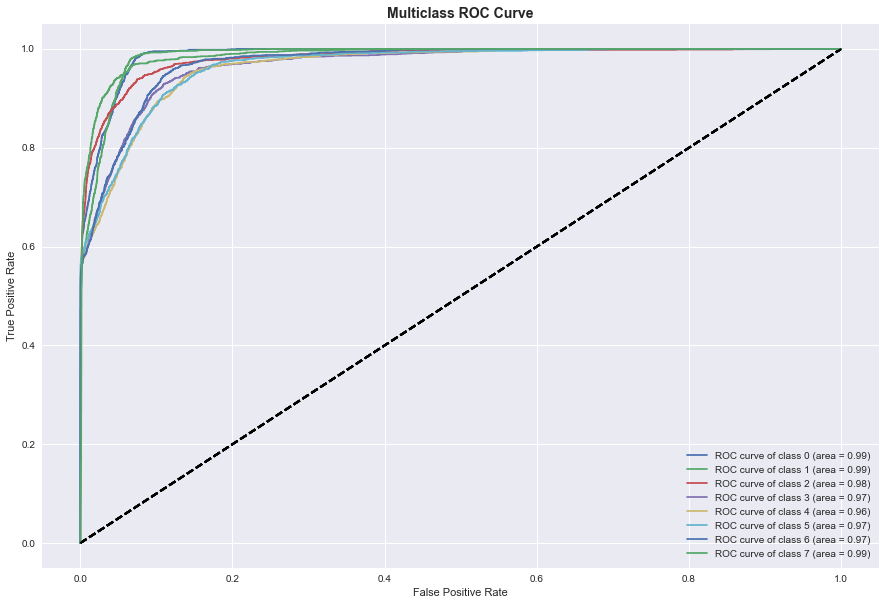

In [15]:
plt.figure(figsize=(15,10))
plt.title('Multiclass ROC Curve', font=FONT, weight='bold')
for i in range(8):
    y_preds_prob = final_pipeline.predict_proba(X_test)[:,i]
    fpr, tpr, thresholds = roc_curve(y_test,  y_preds_prob, pos_label=i+1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc))
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right");

In [39]:
y_preds_prob = final_pipeline.predict_proba(X_test)

print('Area Under Curve "One vs. Rest"')
print(roc_auc_score(y_test, y_preds_prob, multi_class='ovr'))
print('')
print('Area Under Curve "One vs. One"')
print(roc_auc_score(y_test, y_preds_prob, multi_class='ovo'))

Area Under Curve "One vs. Rest"
0.9750002763387394

Area Under Curve "One vs. One"
0.9749670535632057


Compared to the original model, after tuning we've managed to jump by ~3% in AUC scores, and a decrease in error by almost half!

In [10]:
coefficients = final_pipeline.named_steps['logisticregression'].coef_.flatten()

zipped = zip(feature_names, coefficients)
df = pd.DataFrame(zipped, columns=["feature", "value"])
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

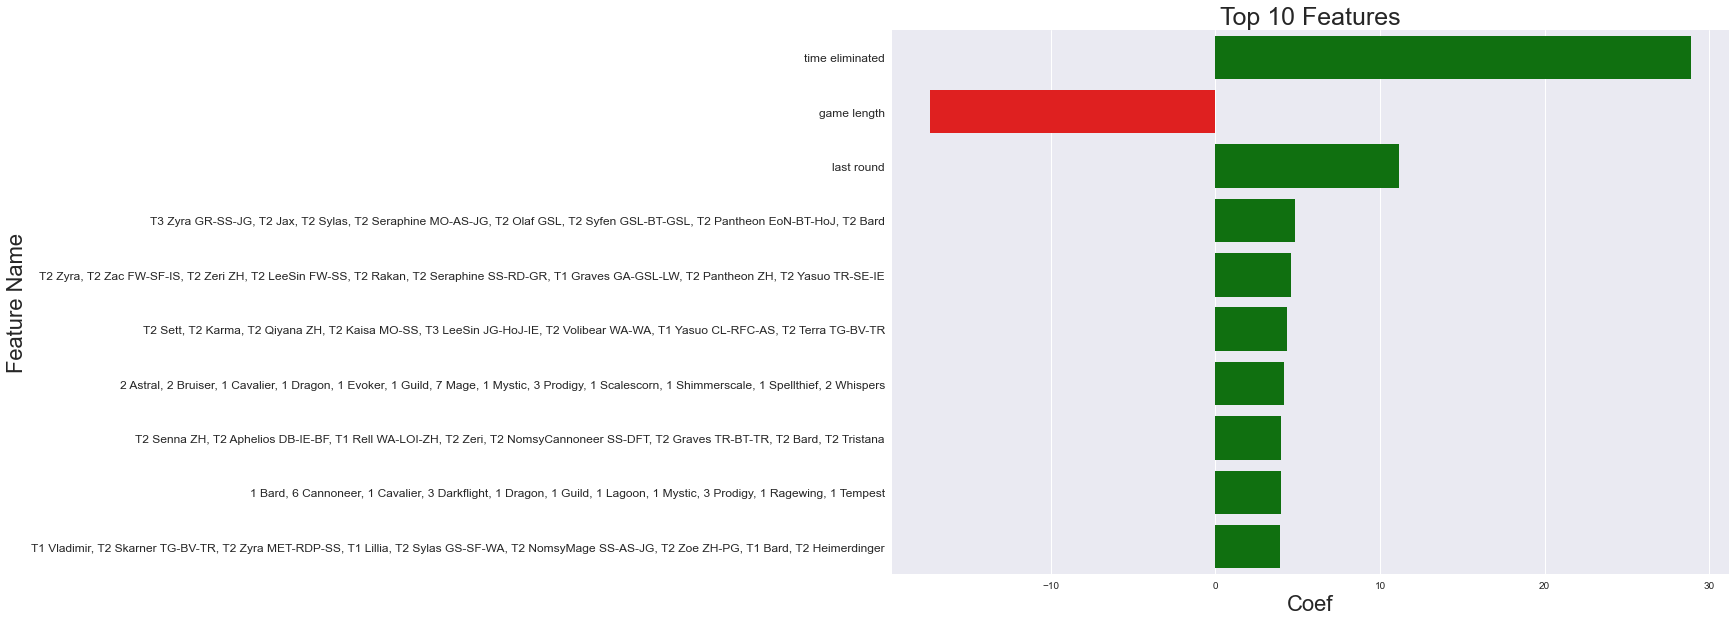

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.barplot(y="feature",
            x="value",
            data=df.head(10),
           palette=df.head(10)["colors"])
labels = ['time eliminated', 'game length', 'last round',
          'T3 Zyra GR-SS-JG, T2 Jax, T2 Sylas, T2 Seraphine MO-AS-JG, T2 Olaf GSL, T2 Syfen GSL-BT-GSL, T2 Pantheon EoN-BT-HoJ, T2 Bard',
          'T2 Zyra, T2 Zac FW-SF-IS, T2 Zeri ZH, T2 LeeSin FW-SS, T2 Rakan, T2 Seraphine SS-RD-GR, T1 Graves GA-GSL-LW, T2 Pantheon ZH, T2 Yasuo TR-SE-IE',
          'T2 Sett, T2 Karma, T2 Qiyana ZH, T2 Kaisa MO-SS, T3 LeeSin JG-HoJ-IE, T2 Volibear WA-WA, T1 Yasuo CL-RFC-AS, T2 Terra TG-BV-TR',
          '2 Astral, 2 Bruiser, 1 Cavalier, 1 Dragon, 1 Evoker, 1 Guild, 7 Mage, 1 Mystic, 3 Prodigy, 1 Scalescorn, 1 Shimmerscale, 1 Spellthief, 2 Whispers',
          'T2 Senna ZH, T2 Aphelios DB-IE-BF, T1 Rell WA-LOI-ZH, T2 Zeri, T2 NomsyCannoneer SS-DFT, T2 Graves TR-BT-TR, T2 Bard, T2 Tristana',
          '1 Bard, 6 Cannoneer, 1 Cavalier, 3 Darkflight, 1 Dragon, 1 Guild, 1 Lagoon, 1 Mystic, 3 Prodigy, 1 Ragewing, 1 Tempest',
          'T1 Vladimir, T2 Skarner TG-BV-TR, T2 Zyra MET-RDP-SS, T1 Lillia, T2 Sylas GS-SF-WA, T2 NomsyMage SS-AS-JG, T2 Zoe ZH-PG, T1 Bard, T2 Heimerdinger']
          
ax.set_yticklabels(labels, fontsize=12)
ax.set_title("Top 10 Features", fontsize=25)
ax.set_xlabel("Coef", fontsize=22)
ax.set_ylabel("Feature Name", fontsize=22);

What is the most impactful composition that determines predicting rank? 

What are the most impactful champions along with their item set ups that determines predicting rank? 


* Most impactful composition: 2 Astral, 2 Bruiser, 1 Cavalier, 1 Dragon, 1 Evoker, 1 Guild, 7 Mage, 1 Mystic, 3 Prodigy, 1 Scalescorn, 1 Shimmerscale, 1 Spellthief, 2 Whispers


* Most impactful champions along with items: T3 Zyra GuinsooRageblade-StattikShiv-JeweledGauntlet, T2 Jax, T2 Sylas, T2 Seraphine Morellonomicon-ArchangelStaff-JeweledGauntlet, T2 Olaf Giantslayer, T2 Syfen Giantslayer-Bloodthirster-Giantslayer, T2 Pantheon EdgeofNight-Bloodthirster-HandofJustice, T2 Bard